INSTALL REQUIRED PACKAGES

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.0 MB/s eta 0:00:00


IMPORTING REQUIRED FRAMEWORKS

In [ ]:
import numpy as np
import json
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import gc
from transformers import BertTokenizer , BertModel
import matplotlib.pyplot as plt
device = torch.device('cuda')
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm

READ THE INPUT INTENT.JSON FILE

In [ ]:
with open('/content/drive/MyDrive/archive (4)/Intent.json') as f:
    data = json.load(f)

CONFIGURATION

In [ ]:
class cfg:
    num_classes=22
    epochs=15
    batch_size=10
    lr=1e-5
    max_length=15

DEFINING THE TRAINING DATAFRAME

In [ ]:
df = pd.DataFrame(data['intents'])
df.head()

,intent,text,responses,extension,context,entityType,entities
0,Greeting,"[Hi, Hi there, Hola, Hello, Hello there, Hya, ...","[Hi human, please tell me your GeniSys user, H...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingUserRequest', 'clea...",NA,[]
1,GreetingResponse,"[My user is Adam, This is Adam, I am Adam, It ...","[Great! Hi <HUMAN>! How can I help?, Good! Hi ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo'..."
2,CourtesyGreeting,"[How are you?, Hi how are you?, Hello how are ...","[Hello, I am great, how are you? Please tell m...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'CourtesyGreetingUserRequest...",NA,[]
3,CourtesyGreetingResponse,"[Good thanks! My user is Adam, Good thanks! Th...","[Great! Hi <HUMAN>! How can I help?, Good! Hi ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 5, 'rangeTo'..."
4,CurrentHumanQuery,"[What is my name?, What do you call me?, Who d...","[You are <HUMAN>! How can I help?, Your name i...",{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]


In [ ]:
df_patterns = df[['text', 'intent']]
df_responses = df[['responses', 'intent']]
df_patterns.head()

,text,intent
0,"[Hi, Hi there, Hola, Hello, Hello there, Hya, ...",Greeting
1,"[My user is Adam, This is Adam, I am Adam, It ...",GreetingResponse
2,"[How are you?, Hi how are you?, Hello how are ...",CourtesyGreeting
3,"[Good thanks! My user is Adam, Good thanks! Th...",CourtesyGreetingResponse
4,"[What is my name?, What do you call me?, Who d...",CurrentHumanQuery


In [ ]:
df_patterns = df_patterns.explode('text')
df_patterns.head()

,text,intent
0,Hi,Greeting
0,Hi there,Greeting
0,Hola,Greeting
0,Hello,Greeting
0,Hello there,Greeting


FINING THE COUNT DISTRIBUTION OF GIVEN INTENTS

<Axes: xlabel='intent'>

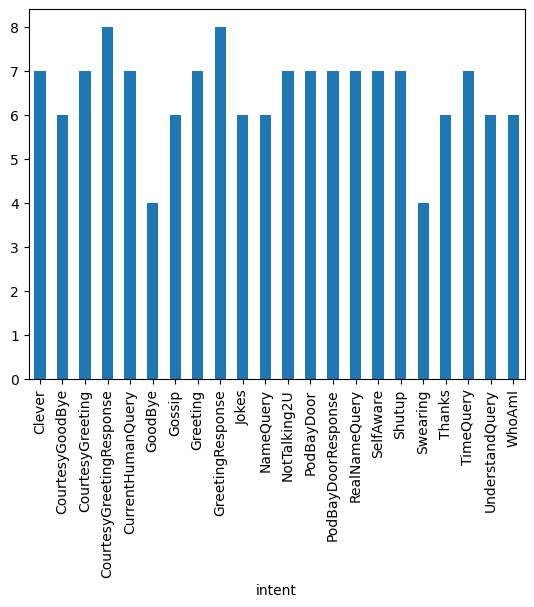

In [ ]:
df_patterns.groupby(['intent']).size().plot.bar()

In [ ]:
df=df_patterns.copy()

DEFINING THE LABELS

In [ ]:
s=set(list(df['intent']))
j=0
labels={}
for i in s:
    labels[i]=j
    j+=1

In [ ]:
labels

{'WhoAmI': 0,
 'Swearing': 1,
 'SelfAware': 2,
 'UnderstandQuery': 3,
 'GreetingResponse': 4,
 'PodBayDoor': 5,
 'TimeQuery': 6,
 'CourtesyGoodBye': 7,
 'Thanks': 8,
 'NotTalking2U': 9,
 'Shutup': 10,
 'CourtesyGreetingResponse': 11,
 'GoodBye': 12,
 'CurrentHumanQuery': 13,
 'PodBayDoorResponse': 14,
 'CourtesyGreeting': 15,
 'NameQuery': 16,
 'Greeting': 17,
 'Jokes': 18,
 'Clever': 19,
 'Gossip': 20,
 'RealNameQuery': 21}

DEFINIG THE TOKENIZER AND DATASET

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['intent']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = cfg.max_length, truncation=True,
                                return_tensors="pt") for text in df['text']]


    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

HERE I USED BERT MODEL FOLLOWED BY LINEAR LAYER

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.2):

        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, cfg.num_classes)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)


        return (linear_output)

SPLITTING THE DATA INTO TRAIN AND VALIDATION

In [ ]:
df_train, df_val = np.split(df.sample(frac=1, random_state=42), [int(.9*len(df))])

print(len(df_train), len(df_val))

128 15


THE TRAINING AND EVALUATION LOOP

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=cfg.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=cfg.batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=cfg.lr)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()


                train_label=train_label.to(device)
                output=output.to(device)
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()


            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)
                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc


            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

TO FREE UP SPACE

In [ ]:
gc.collect()

12

TRAINING THE MODEL

In [ ]:
EPOCHS = cfg.epochs
model = BertClassifier()
LR = cfg.lr

train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 13/13 [00:37<00:00,  2.91s/it]


Epochs: 1 | Train Loss:  0.323                 | Train Accuracy:  0.078                 | Val Loss:  0.421                 | Val Accuracy:  0.067


100%|██████████| 13/13 [00:33<00:00,  2.56s/it]


Epochs: 2 | Train Loss:  0.298                 | Train Accuracy:  0.117                 | Val Loss:  0.391                 | Val Accuracy:  0.133


100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Epochs: 3 | Train Loss:  0.284                 | Train Accuracy:  0.203                 | Val Loss:  0.384                 | Val Accuracy:  0.133


100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


Epochs: 4 | Train Loss:  0.264                 | Train Accuracy:  0.320                 | Val Loss:  0.367                 | Val Accuracy:  0.267


100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


Epochs: 5 | Train Loss:  0.246                 | Train Accuracy:  0.406                 | Val Loss:  0.355                 | Val Accuracy:  0.267


100%|██████████| 13/13 [00:30<00:00,  2.32s/it]


Epochs: 6 | Train Loss:  0.218                 | Train Accuracy:  0.602                 | Val Loss:  0.327                 | Val Accuracy:  0.400


100%|██████████| 13/13 [00:30<00:00,  2.38s/it]


Epochs: 7 | Train Loss:  0.195                 | Train Accuracy:  0.766                 | Val Loss:  0.319                 | Val Accuracy:  0.533


100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


Epochs: 8 | Train Loss:  0.174                 | Train Accuracy:  0.844                 | Val Loss:  0.302                 | Val Accuracy:  0.600


100%|██████████| 13/13 [00:30<00:00,  2.33s/it]


Epochs: 9 | Train Loss:  0.146                 | Train Accuracy:  0.945                 | Val Loss:  0.281                 | Val Accuracy:  0.733


100%|██████████| 13/13 [00:30<00:00,  2.31s/it]


Epochs: 10 | Train Loss:  0.131                 | Train Accuracy:  0.961                 | Val Loss:  0.257                 | Val Accuracy:  0.733


100%|██████████| 13/13 [00:30<00:00,  2.32s/it]


Epochs: 11 | Train Loss:  0.115                 | Train Accuracy:  0.984                 | Val Loss:  0.260                 | Val Accuracy:  0.733


100%|██████████| 13/13 [00:30<00:00,  2.34s/it]


Epochs: 12 | Train Loss:  0.103                 | Train Accuracy:  1.000                 | Val Loss:  0.228                 | Val Accuracy:  0.733


100%|██████████| 13/13 [00:30<00:00,  2.31s/it]


Epochs: 13 | Train Loss:  0.088                 | Train Accuracy:  0.992                 | Val Loss:  0.207                 | Val Accuracy:  0.733


100%|██████████| 13/13 [00:30<00:00,  2.32s/it]


Epochs: 14 | Train Loss:  0.079                 | Train Accuracy:  1.000                 | Val Loss:  0.202                 | Val Accuracy:  0.733


100%|██████████| 13/13 [00:32<00:00,  2.49s/it]


Epochs: 15 | Train Loss:  0.066                 | Train Accuracy:  1.000                 | Val Loss:  0.195                 | Val Accuracy:  0.733


I GOT THE VALIDATION ACCURACY OF 73.3 %